# Previsão Temperatura Horária 🌡️

## imports

In [4]:
%pip install -r requirements.txt > /dev/null
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Limpando dataset:

In [5]:
class WeatherDataProcessor:
    def __init__(self, encoding='latin1', separator=';', decimal=','):
        self.encoding = encoding
        self.separator = separator
        self.decimal = decimal

    def read_file(self, file_path):
      
        try:
            df = pd.read_csv(
                file_path, 
                sep=self.separator, 
                decimal=self.decimal, 
                encoding=self.encoding,
                skiprows=8
            )
            return df
        except Exception as e:
            print(f"Erro ao ler o arquivo {file_path}: {e}")
            return None

    def clean_data(self, df):
      
        if df is None:
            return None

        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        threshold = len(df.columns) * 0.5
        
        df_cleaned = df.dropna(thresh=int(threshold))
        
        return df_cleaned

    def process_file(self, file_path):
        
        print(f"Processando: {file_path}")
        df = self.read_file(file_path)
        if df is not None:
            print(f"Shape original: {df.shape}")
            df_cleaned = self.clean_data(df)
            if df_cleaned is not None:
                print(f"Shape após limpeza: {df_cleaned.shape}")
            return df_cleaned
        return None

    def prepare_features(self, df):
       
        column_keywords = {
            'temperatura': ['bulbo seco, horaria', 'bulbo seco'],
            'umidade': ['umidade relativa do ar, horaria'],
            'vento_velocidade': ['velocidade horaria', 'velocidade'],
            'vento_rajada': ['rajada maxima', 'rajada'],
            'radiacao': ['radiacao global'],
            'precipitacao': ['precipitacao total, horario', 'precipitacao']
        }
        
        
        available_cols = []
        rename_dict = {}
        
        for new_name, keywords in column_keywords.items():
            found = False
            for col in df.columns:
                col_lower = col.lower()
                for keyword in keywords:
                    if keyword in col_lower:
                        if col not in available_cols:  # Evita duplicatas
                            available_cols.append(col)
                            rename_dict[col] = new_name
                            found = True
                            break
                if found:
                    break
        
        
        if not available_cols:
            print("Erro: Nenhuma coluna de feature encontrada no DataFrame.")
            return None, None
        
        df_features = df[available_cols].copy()
        df_features.rename(columns=rename_dict, inplace=True)
        
        print(f"Shape antes de dropna: {df_features.shape}")
        print(f"Valores nulos por coluna:\n{df_features.isnull().sum()}")
        
        null_threshold = len(df_features) * 0.5
        cols_to_keep = [col for col in df_features.columns 
                        if df_features[col].isnull().sum() < null_threshold]
        
        removed_cols = set(df_features.columns) - set(cols_to_keep)
        if removed_cols:
            print(f"Colunas removidas por excesso de nulos: {removed_cols}")
        
        df_features = df_features[cols_to_keep]
        
        df_features = df_features.dropna()
        
        print(f"Shape após dropna: {df_features.shape}")
        
        if 'temperatura' not in df_features.columns:
            print("Erro: Coluna de temperatura não encontrada.")
            return None, None
        
        if len(df_features) == 0:
            print("Erro: Não há dados suficientes após remover valores nulos.")
            return None, None
        
        df_features['temperatura_futura'] = df_features['temperatura'].shift(-1)
        
        df_features = df_features.dropna()
        
        feature_cols = [c for c in df_features.columns if c not in ['temperatura_futura']]
        X = df_features[feature_cols]
        y = df_features['temperatura_futura']
        
        return X, y

    def train_model(self, X, y, test_size=0.2, random_state=42):
        if X is None or y is None:
            print("Erro: Dados de entrada inválidos para treinamento.")
            return None
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, shuffle=False
        )
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        print(f"\n=== Resultados do Modelo de Regressão Linear ===")
        print(f"RMSE (Treino): {rmse_train:.4f} °C")
        print(f"RMSE (Teste):  {rmse_test:.4f} °C")
        print(f"R² Score:      {model.score(X_test, y_test):.4f}")
        
        print(f"\nCoeficientes das Features:")
        for feature, coef in zip(X.columns, model.coef_):
            print(f"  {feature}: {coef:.4f}")
        print(f"  Intercepto: {model.intercept_:.4f}")
        
        return {
            'model': model,
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'y_pred_train': y_pred_train, 'y_pred_test': y_pred_test,
            'rmse_train': rmse_train, 'rmse_test': rmse_test
        }

    def plot_predictions(self, results, figsize=(14, 6)):
     
        if results is None:
            print("Erro: Resultados inválidos para plotagem.")
            return
        
        y_test = results['y_test']
        y_pred_test = results['y_pred_test']
        rmse_test = results['rmse_test']
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        ax1 = axes[0]
        x_range = range(len(y_test))
        ax1.plot(x_range, y_test.values, label='Temperatura Real', color='blue', alpha=0.7)
        ax1.plot(x_range, y_pred_test, label='Temperatura Prevista', color='red', alpha=0.7, linestyle='--')
        ax1.fill_between(x_range, y_pred_test - rmse_test, y_pred_test + rmse_test, 
                         color='red', alpha=0.1, label=f'Intervalo RMSE (±{rmse_test:.2f}°C)')
        ax1.set_xlabel('Observações (Horas)')
        ax1.set_ylabel('Temperatura (°C)')
        ax1.set_title('Previsão de Temperatura: Real vs. Prevista')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[1]
        ax2.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', linewidth=0.5)
        
        min_val = min(y_test.min(), y_pred_test.min())
        max_val = max(y_test.max(), y_pred_test.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Previsão Perfeita')
        
        ax2.set_xlabel('Temperatura Real (°C)')
        ax2.set_ylabel('Temperatura Prevista (°C)')
        ax2.set_title(f'Dispersão: Real vs. Prevista (RMSE: {rmse_test:.2f}°C)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

    def predict_temperature(self, df):
        print("\n=== Iniciando Previsão de Temperatura ===")
        
        X, y = self.prepare_features(df)
        if X is None:
            return None
        
        print(f"Features utilizadas: {list(X.columns)}")
        print(f"Total de amostras: {len(X)}")
        
        results = self.train_model(X, y)
        
        if results is not None:
            self.plot_predictions(results)
        
        return results



Processando: ../data/INMET_NE_PE_A307_PETROLINA_01-01-2023_A_31-12-2023.CSV
Shape original: (8760, 20)
Shape após limpeza: (5794, 19)

Primeiras linhas do DataFrame processado:
            Data  Hora UTC  PRECIPITACAO TOTAL, HORARIO (mm)  \
2942  2023/05/03  1400 UTC                              17.2   
2943  2023/05/03  1500 UTC                              15.4   
2944  2023/05/03  1600 UTC                               9.8   
2945  2023/05/03  1700 UTC                               0.0   
2946  2023/05/03  1800 UTC                               0.0   

      PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
2942                                              971.7       
2943                                              970.8       
2944                                              969.7       
2945                                              968.6       
2946                                              968.2       

      PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
29

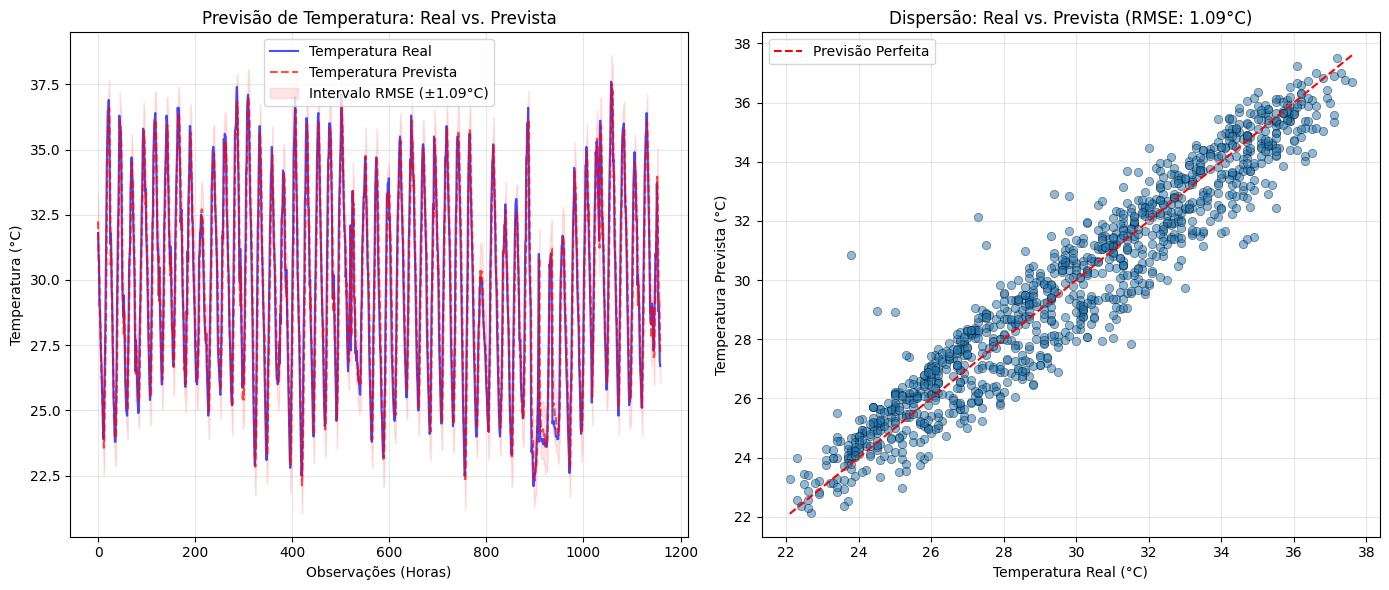

In [6]:
file_path = "../data/INMET_NE_PE_A307_PETROLINA_01-01-2023_A_31-12-2023.CSV"

if os.path.exists(file_path):
    processor = WeatherDataProcessor()
    df_final = processor.process_file(file_path)
    
    if df_final is not None:
        print("\nPrimeiras linhas do DataFrame processado:")
        print(df_final.head())
        
        # Executa a previsão de temperatura
        results = processor.predict_temperature(df_final)
else:
    print(f"Arquivo não encontrado para teste: {file_path}")